# Graph Classification

## Calling the required packages here

In [1]:
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Creating the graph

We investigated the path length distribution in directed graphs and how one can classify them az embeddable or not embeddable in a two-dimesional Lorentzian Manifold, the result obtained for average path length distribution was
$$n_k = \frac{N!}{(N-k+1)!}\sum_{i=0}^{N-k+1}{N-k+1\choose i}(-1)^i\frac{\Gamma(i+1)}{\Gamma(i+k)^2}f_{i,k}$$
where $N$ is the total number of points, $k$ is the length of the chain, and $\Gamma$ is the Gamma function.<br>
$f_{i,k}$ is a function that satisfies the following recursion relation
$$f_{i,k}=\sum_{j=0}^i\Gamma(1+i-j)f_{j,k-1}$$
and the initial condition for this recurion relation can be formulized as
$$f_{i,1}=\Gamma(i+1).$$

To be able to compare the theoretical results with simulations we need to produce some graphs and look at their features and compare their average with the theory. To do so we first introduce some functions.

In [2]:
#determining if xf is in the future of xp
def future(xf,xp,d):
    r=0
    for i in range(1,d):
        r=r+(xf[i]-xp[i])**2
    R=np.sqrt(r)
    if xp[0]<xf[0] and R< xf[0]-xp[0]:
        return 1
    else:
        return 0
#determining if xm is between xp and xf      
def condition(xf,xm,xp,d):
    if future(xf,xm,d)==1 and future(xm,xp,d)==1:
        return 0
    else:
        return 1
#determining if xf and xp are nearest neighbors
def empty (xf,xp,L,d):
    count=0
    for i in range(len(L)):
        if condition(xf,L[i],xp,d)==0:
            return 0
    if count==0:
        return 1

## 1. Sprinkling Points

In [3]:
def sprinkler(N,D):
    '''Sprinkling points to create a graph'''
    ##################
    #D represent the dimension
    ###################
    #defining the box that the points are being sprinkled in at random.
    boxdim=[1]*D
    xmin=[0]*D
    xmax=[1]+[0]*(D-1)
    ###################
    points=[xmin]
    while len(points)<N+1:
        point=[np.random.uniform(0,1)]+[np.random.uniform(-1.0/2,1.0/2) for dim in range(1,D)]#a list of length d of random numbers
        if future(xmax,point,D)==1 and future(point,xmin,D)==1:# if it is in the required interval
            points.append(point)
    points.append(xmax)
    return points
    ###################

The sprinkling needs to be done through a rejection process to be fair and uniform in the intersection of chronological past of pont $q$ and chronological future of $p$. To do so the points that fall in the red shaded region in the figure will be rejected and the points that fall into the green shaded region will be accepted as points in the graph.<br>
* A better way to sprinkle is to change the coordinates to sprinkle the points directly in green region with uniform density.(For our purpose the time saved is neglegible and there is no need for such a coordinate transformation, but it is a straight forward task).

![rejection](Allowed.png)

## 2. Forming the Link matrix

A directed graph can be identified with two types of matrices which contain exactly equal amount of information but each are useful for some applications. <strong> Link</strong> matrix and <strong>Relations</strong> matrix. Since we are dealing with path length distribution, we are concerned about the Link matrix.<br>
A Link matrix for a graph with $N$ points is an $N\times N$ matrix, with $1$s where there is a direct connection between two points and $0$s everywhere else. Raising Link marix to power $k$, can give us the number of paths of length $k$
$$(L^k)_{i,j} = n_k$$

In [4]:
def nnfinder(N,D,s):
    '''Link and Relations matrix creator'''
    ###################
    #link=[[0]*(N+2) for i in range(N+2)]
    #Relations=[[0]*(N+2) for i in range(N+2)]
    #for e1 in range(len(s)):
    #    for e2 in range(len(s)):
    #        if future(s[e2],s[e1],D)==1:# if s[e2] in the future of s[e1]
    #            Relations[e1][e2]=1
    #            if empty(s[e2],s[e1],s,D)==1: # if interval s[e1] to s[e2] is empty
    #                link[e1][e2]=1
    link = [[1 if future(s[e2], s[e1], D)==1 and empty(s[e2], s[e1],s,D) == 1 else 0 
              for e2 in range(len(s))]for e1 in range(len(s))]
    ##The commented calculation is more beneficiary timewise when both link and relation matrices are required.
    return link

## 3. Finding the distributions and their features

The distribution of pathlength in a directed graph that is embeddable in a manifold, or some of its features can be good measure for defining the manifoldlikeness and classification of graphs.

In [5]:
def pathfinder(link,N):
    '''Distribution Finder'''
    ######################
    mlinks=np.matrix(link)
    zero = np.zeros((len(mlinks), len(mlinks)))
    A=np.identity(len(mlinks))
    pathlength=[]
    m=1
    tot=[]
    while m<=len(link)and not np.array_equal(A,zero):
        #if np.array_equal(A,zero):
        #    m=len(link)+1
        #else:
        A=A*mlinks
        pathlength.append([ m , A[0,-1]])
        tot.append(A[0,-1])
        m=m+1
    totpath=sum(tot)
    ##################################
    #finding the maximum and the width
    peak_idx=tot.index(max(tot))
    peak=pathlength[peak_idx][0]
    half_height=max(tot)/2.0
    low = 0; high = 0
    for i in range(len(tot)-1):
        if tot[i]<=half_height and tot[i+1]>half_height:
            low=i+1/2.0
        if tot[i+1]<=half_height and tot[i]>half_height:
            high=i+1/2.0
    half_width=high-low
    #print '\r'+'for %d points we found width=%d and peak at %d'%(N,half_width,peak),
    return peak,half_width,tot

The data is now ready to be saved and visualized

In [6]:
nsp=100#number of sprinklings
N=[100, 200, 300]#, 400, 500]#, 600, 700, 800, 900, 1000]#values for number of points
num=[0]*(nsp*len(N))
p=[0]*(nsp*len(N)); avgPeak = []; stdPeak = []
w=[0]*(nsp*len(N)); avgWidth = []; stdWidth = []
y=[0]*(nsp*len(N));old=[]
Data = []
dist = []; diststd = []
c=['r','k','b']
D=5;cnt = 1
for d in range(2,D):
    #print '%d dimensions'%d
    counter=0; lst = [];
    for sp in range(nsp):
        #print '\n%d'%(sp+1)
        for n in N:
            s=sprinkler(n,d)
            link=nnfinder(n,d,s)
            [p[counter],w[counter],total]=pathfinder(link,n)
            t = total.append(n)
            Data.append(t)
            num[counter]=n
            y[counter]=d
            counter=counter+1
            print '\r'+'%1.2f%%'%(100/(len(N)*nsp*3.)*(cnt)),
            cnt+=1
        lst.append(total)
        #######################
        #saving data
        data={'peak':p,'width':w,'N':num}
        np.save('%d-D_Minkowski'%d,data)
    ####
    #averaging all the sprinklings
    Pavgs = []; Pstds = []
    Wavgs = []; Wstds = []
    for i in range(len(N)):
        Pavgs.append(np.average([p[i+j*len(N)] for j in range(nsp)]))
        Pstds.append(np.std([p[i+j*len(N)] for j in range(nsp)]))
        Wavgs.append(np.average([w[i+j*len(N)] for j in range(nsp)]))
        Wstds.append(np.std([w[i+j*len(N)] for j in range(nsp)]))
    avgPeak.append(Pavgs); avgWidth.append(Wavgs)
    stdPeak.append(Pstds); stdWidth.append(Wstds)
            
    maxlen = 0
    for el in lst:
        if len(el) > maxlen:
            maxlen = len(el)
    avg = [np.average([el[i] if len(el)-1>=i else 0 for el in lst]) for i in range(maxlen)]
    std = [np.std([el[i] if len(el)-1>=i else 0 for el in lst]) for i in range(maxlen)]
    dist.append(avg)
    diststd.append(std)

100.00%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 


We save the half-width, peak position and the total number of points as the features of the distributions.

## Visualization

We can visualize the distributions. We use logarithmic plot because the distributions are very different in different dimensions.

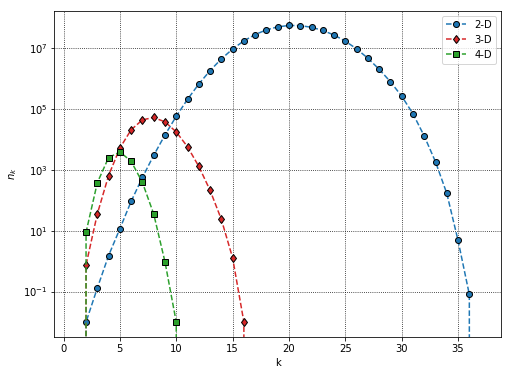

In [7]:
markers = ['o', 'd', 's']; colors = ['tab:blue', 'tab:red', 'tab:green']
figure(figsize=(8,6))
cnt = 0
for distribution in dist:
    x = range(1, len(distribution)+1)
    semilogy(x, distribution, '--', marker = markers[cnt], c = colors[cnt], mec = 'k', label = '%d-D'%(cnt+2))
    cnt+=1
grid(linestyle = 'dotted', c = 'k')
xlabel('k')
ylabel(r'$n_k$')
legend(loc =1)
show()

The distributions in nonlogarithmic plots look a lot like Gaussian (Normal) distribution, which can be characterized with their with and hight (or peak location interchangably).<br>
Now we compare these results with the statistical model that we built.

![distribution](logplot_50p_1000sp.png)

As we can see there is a very good agreement between the theoretical model and the simulations even in the logarithmic scale.

Now let's look at the parameter space that we want to use to classify the graphs. The Peak position and the width of the distribution will be shown as axes for the graph and the number of points will be identified by a color bar.

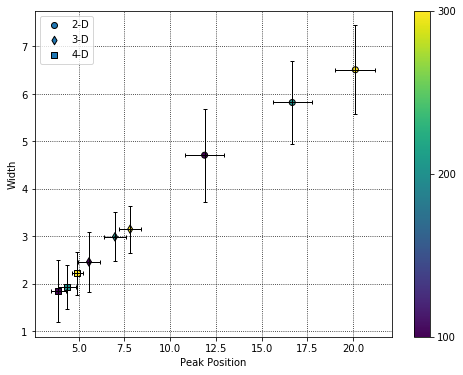

In [8]:
figure(figsize = (8,6))
for i in range(len(avgPeak)):
    errorbar(avgPeak[i], avgWidth[i], xerr=stdPeak[i], yerr=stdWidth[i], marker =None,
             ls = 'none', ecolor = 'black', elinewidth =1, capsize = 2)
    scatter(avgPeak[i], avgWidth[i], edgecolor = 'k', marker = markers[i],c=N, label = '%d-D'%(i+2))
xlabel('Peak Position')
ylabel('Width')
colorbar(ticks = N)
legend(loc=2)
grid(linestyle = 'dotted', c = 'k')
show()

# Classification

The data is labeled by the dimension and we want to be able to classify the graphs based on the dimensionality of the manifold that they can be embedded on.

### -Logistic Regression

In [9]:
data1 = np.load('./2-D_Minkowski.npy')
data2 = np.load('./3-D_Minkowski.npy')
data3 = np.load('./4-D_Minkowski.npy')

TwoD = data1.tolist()
ThreeD = data2.tolist()
FourD = data3.tolist()

DataSet1 = pd.DataFrame.from_dict(TwoD)
DataSet2 = pd.DataFrame.from_dict(ThreeD)
DataSet3 = pd.DataFrame.from_dict(FourD)

y = [2]*len(DataSet1)+[3]*len(DataSet2)+[4]*len(DataSet3)
X = DataSet1.append(DataSet2).append(DataSet3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 1)

clf = LogisticRegression(multi_class = 'ovr')
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

1.0


### -Random Forest Classifier

In [10]:
clf_r = RandomForestClassifier()
clf_r.fit(X_train, y_train)
print clf_r.score(X_test, y_test)

1.0


It is a completely successful parametrization of the graphs, and we see that it is possible to classify them even with a logistic regression method.

### -Neural Networks/Tensorflow

Below is a neural network algorithm, using tensorflow. 

In [170]:
import tensorflow as tf

n_nodes_l1 = 500
n_nodes_l2 = 500
n_nodes_l3 = 500

n_classes = 3
n_variables = len(X_train.iloc[0])

y_train_new = [[0]*3 for _ in y_train]
for _ in range(len(y_train)):
    y_train_new[_][y_train[_]-2] = 1
    
y_test_new = [[0]*3 for _ in y_test]
for _ in range(len(y_test)):
    y_test_new[_][y_test[_]-2] = 1

x = tf.placeholder('float', [None, n_variables])
y = tf.placeholder('float')

def nn_model(inpt):
    hidden_1_layer = {'weight':tf.Variable(tf.random.normal([n_variables, n_nodes_l1])),
                    'biases':tf.Variable(tf.random.normal([n_nodes_l1]))}
    hidden_2_layer = {'weight':tf.Variable(tf.random.normal([n_nodes_l1, n_nodes_l2])), 
                   'biases': tf.Variable(tf.random.normal([n_nodes_l2]))}
    hidden_3_layer = {'weight':tf.Variable(tf.random.normal([n_nodes_l2, n_nodes_l3])), 
                   'biases': tf.Variable(tf.random.normal([n_nodes_l3]))}
    output_layer= {'weight': tf.Variable(tf.random.normal([n_nodes_l3, n_classes])), 
                  'biases':tf.Variable(tf.random.normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(inpt, hidden_1_layer['weight']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weight']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weight']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    
    output = tf.add(tf.matmul(l3, output_layer['weight']), output_layer['biases'])
    
    return output

def training_nn(x):
    prediction = nn_model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = prediction, labels = y))
    Optimizer = tf.train.AdamOptimizer(learning_rate = .0001).minimize(cost)
    
    bf_rounds = 500
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        #sess.run(tf.global_variables_initializer())
        for bf_round in range(bf_rounds):
            round_loss = 0
            _, c = sess.run([Optimizer, cost], feed_dict = {x:np.array(X_train), 
                                                            y:np.array(y_train_new)})
            round_loss += c
            print '\r round:%d, loss: %3.2f' %(bf_round+1, round_loss),
        
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print 'Accuracy:', accuracy.eval({x:np.array(X_test),y:np.array(y_test_new)})
        
training_nn(x)

 round:500, loss: 903.61 Accuracy:                                                                     0.84444445
